In [1]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.he as he
import mushroom.data.user_points as points
import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

In [5]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey'
Path(project_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# specifying a channel in multiplex imaging sections to use during registration/visualization
multiplex_channel = 'DAPI'

# scale factors for registration
# each data type identifier will be downsampled by {default_scale}, or scale specified in {dtype_to_scale} (bigwarp registration can be cumbersome with large, full resolution images)
# this scale factor DOES NOT downsample data input to mushroom, mushroom inputs will still be full resolution. It is purely to get bigwarp to run more smoothly.
# here we just downsample every data type by 20%
default_scale = .2

# if you wanted a specific data type to be scaled more or less than other data types, you could specify here
dtype_to_scale = {
#     'multiplex': .1, # for example, if you uncommented this line multiplex data would be scaled by .1 instead of .2
}

In [19]:
filepath = '/diskmnt/primary/Xenium/data/20240403__184957__20240403_SenNet-Liver/output-XETG00122__0022765__SN001H1-Md1Fp2bUs3_1__20240403__185043'
scaler=.1
normalize=False
transcripts=False
base=np.e

In [21]:
import scanpy as sc
import tifffile
from tifffile import TiffFile

In [22]:
if filepath.split('.')[-1] == 'h5ad':
    adata = sc.read_h5ad(filepath)
else:
    adata = sc.read_10x_h5(
        filename=os.path.join(filepath, 'cell_feature_matrix.h5')
    )

    df = pd.read_csv(
        os.path.join(filepath, 'cells.csv.gz')
    )
    df = df.set_index('cell_id')
    adata.obs = df.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy().astype(int)

    if transcripts:
        df = pd.read_csv(
            os.path.join(filepath, 'transcripts.csv.gz')
        )
        df = df.set_index('transcript_id')
        adata.uns['transcripts'] = df.copy()


    if os.path.exists(os.path.join(filepath, 'morphology_focus.ome.tif')):
        fp = os.path.join(filepath, 'morphology_focus.ome.tif')
        is_v1 = True
    elif os.path.exists(os.path.join(filepath, 'morphology.ome.tif')):
        fp = os.path.join(filepath, 'morphology.ome.tif')
        is_v1 = False
    else:
        raise RuntimeError(f'Could not find morphology.ome.tif')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [23]:
tf = tifffile.TiffFile(fp)
ppm = 1 / float(re.findall(r'PhysicalSizeX="([\.0-9]*)" ', tf.ome_metadata)[0])

img = tifffile.imread(fp).astype(np.float32)
img.shape

(12, 47736, 42666)

In [ ]:

    tf = tifffile.TiffFile(fp)
    ppm = 1 / float(re.findall(r'PhysicalSizeX="([\.0-9]*)" ', tf.ome_metadata)[0])

    img = tifffile.imread(fp).astype(np.float32)

    hires = TF.resize(
        torch.tensor(img).unsqueeze(0),
        (int(img.shape[0] * scaler), int(img.shape[1] * scaler)),
        antialias=True
    ).squeeze().numpy()

    if hires.max() > 255.: # check for uint16
        hires /= 65535.
        hires *= 255
        hires = hires.astype(np.uint8)

    adata.uns['spatial'] = {
        'key': {
            'images': {'hires': hires},
            'scalefactors': {
                'tissue_hires_scalef': scaler * ppm,
                'spot_diameter_fullres': 10.,
            }
        }
    }

    adata.uns['ppm'] = 1. # coords are in microns

# if sparse, then convert
if 'sparse' in str(type(adata.X)).lower():
    adata.X = adata.X.toarray()

if normalize:
    sc.pp.log1p(adata, base=base)

return adata

## define experiments

#### SN001H1-Md1Fp2b

In [7]:
case = 'SN001H1-Md1Fp2b'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'SN001H1-Md1Fp2b-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'SN001H1-Md1Fp2b-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240403__184957__20240403_SenNet-Liver/output-XETG00122__0022765__SN001H1-Md1Fp2bUs3_1__20240403__185043'
                },
            ] 
        },
        {
            'sid': 'SN001H1-Md1Fp2b-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240126_Human_Liver_SenNet_SN009H1_SN046H1_SN047H1_SN001H1/SN001H1-Md1Fp2b__20240126.ome.tiff'
                },
            ] 
        },
    ]
}

## Write images for registration

In [31]:
target_sid = data_map['target_sid']
item = [item for item in data_map['sections'] if item['sid']==target_sid][0]
dtype = item['data'][0]['dtype'] # first entry by default
filepath = item['data'][0]['filepath']

dtype_root = utils.parse_dtype(dtype)
if dtype_root == 'visium':
    resolution = visium.pixels_per_micron(filepath)
elif dtype_root == 'xenium':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'cosmx':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'multiplex':
    resolution = multiplex.pixels_per_micron(filepath) # assumes pixels.physical_size_x is present in ome
elif dtype_root == 'he':
    resolution = he.pixels_per_micron(filepath) # converts MPP to ppm in .svs files, returns pixels.physical_size_x in ome-tif, otherwise returns whatever is in tif resolution
else: # resolution for points dtype is assumed to be 1. by default
    resolution = 1.

data_map['resolution'] = resolution

target_sid, resolution

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 47736, 42666)
(47736, 42666)


('SN001H1-Md1Fp2b-U1', 1.0)

SN001H1-Md1Fp2b-U1 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 47736, 42666)
(47736, 42666)
SN001H1-Md1Fp2b-U2 multiplex


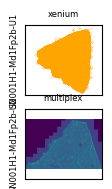

In [32]:
bigwarp.display_data_map(data_map, multiplex_channel=multiplex_channel, gamma=.5)

In [33]:
output_dir = os.path.join(reg_dir, 'unregistered_tifs') # where to write un-registered images to use with bigwarp
Path(output_dir).mkdir(parents=True, exist_ok=True)
output_dir

'/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registration/unregistered_tifs'

In [34]:
# image saving for each data type

def write_st(filepath, output_filepath, dtype, scale=.1):
    if dtype == 'visium':
        adata = visium.adata_from_visium(filepath)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(filepath)
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(filepath)
    else:
        raise RuntimeError(f'{dtype} not valid st data type')

    image_data = next(iter(adata.uns['spatial'].values()))
    
    img = image_data['images']['hires'] # grab image
    
    # need to adjust scale by tissue_hires_scalef because spot/cell coordinates are at a different resolution than the image
    sf = scale / image_data['scalefactors']['tissue_hires_scalef']
    
    dim_order = 'h w' if dtype in ['xenium', 'cosmx'] else 'h w c'
    img = utils.rescale(img, scale=sf, dim_order=dim_order, target_dtype=np.uint8) # scale image    
    
    tifffile.imwrite(output_filepath, img, compression='LZW') # write scaled H&E


def write_multiplex(filepath, output_filepath, channel='DAPI', scale=.1):
    # extract OME-TIF
    channel_to_img = multiplex.extract_ome_tiff(
        filepath, channels=[channel], scale=scale
    )
    
    # conversion to uint8
    img = channel_to_img[channel]
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() # just use max intensity bc not sure what data type range we'll be dealing with
        img *= 255.
        img = img.astype(np.uint8)
        
    print(img.shape)
    tifffile.imwrite(output_filepath, img, compression='LZW')
    

def write_he(filepath, output_filepath, scale=.1):
    img = he.read_he(filepath, scale=scale)
    
    # lin et al has channel dim first
    if img.shape[0] == 3:
        img = rearrange(img, 'c h w -> h w c')

    tifffile.imwrite(output_filepath, img, compression='LZW')

In [35]:
for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0] # use first data type for registration by default
    dtype, filepath = mapping['dtype'], mapping['filepath']
    print(sid, dtype)

    output_filepath = os.path.join(output_dir, f's{idx}_{sid}.tif')

    scale = dtype_to_scale.get(dtype, default_scale)
    if utils.parse_dtype(dtype) in ['visium', 'cosmx', 'xenium']:
        write_st(filepath, output_filepath, dtype, scale=scale)
    elif utils.parse_dtype(dtype) == 'multiplex':
        write_multiplex(filepath, output_filepath, channel=multiplex_channel, scale=scale)
    elif utils.parse_dtype(dtype) == 'he':
        write_he(filepath, output_filepath, scale=scale)
    else:
        raise RuntimeError(f'{dtype} is not a valid data type identifier')

SN001H1-Md1Fp2b-U1 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 47736, 42666)
(47736, 42666)
SN001H1-Md1Fp2b-U2 multiplex
(2379, 3700)


In [36]:
img = next(iter(adata.uns['spatial'].values()))['images']['hires']
img.shape

(4773, 4266)

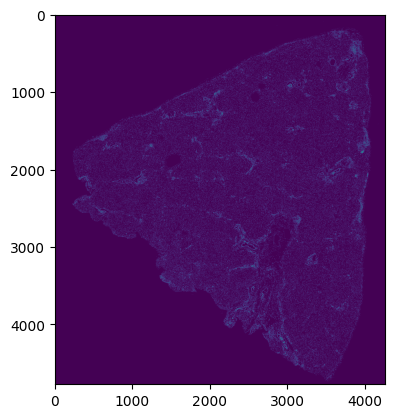

In [37]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [38]:
sorted(utils.listfiles(output_dir))

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registration/unregistered_tifs/s0_SN001H1-Md1Fp2b-U1.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registration/unregistered_tifs/s1_SN001H1-Md1Fp2b-U2.tif']

## post bigwarp registration

In [43]:
registered_dir = os.path.join(project_dir, case, 'registered') # this is where we will put our registered data for each section
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [44]:
fps = sorted(utils.listfiles(reg_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registration/s1_SN001H1-Md1Fp2b-U2_ddf.tif']

In [45]:
target_sid = data_map['target_sid']

sid_to_ddf = {}

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0]
    dtype, filepath = mapping['dtype'], mapping['filepath']
    scale = dtype_to_scale.get(dtype, default_scale)
    
    if sid != target_sid: # initial registration target section will not have ddf
        ddf_fp = os.path.join(reg_dir, f's{idx}_{sid}_ddf.tif')

        assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
        ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
        sid_to_ddf[sid] = ddf

sid_to_ddf.keys()

dict_keys(['SN001H1-Md1Fp2b-U2'])

In [46]:
registered_data_map = copy.deepcopy(data_map)

res = data_map['resolution']

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    for m_idx, mapping in enumerate(item['data']):
        dtype, fp = mapping['dtype'], mapping['filepath']
        print(sid, dtype, fp)
        
        dtype_root = utils.parse_dtype(dtype)
        section_id = f's{idx}_{sid}'
        ddf = sid_to_ddf.get(sid)
        
        if dtype_root == 'he':
            img = he.read_he(fp)
            img = rearrange(img, 'h w c -> c h w') # channel dim must be first
#             print(img.shape, ddf.shape)

            if ddf is not None:
                img = bigwarp.register_he(img, ddf)

            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.tif')
            tifffile.imwrite(
                output_filepath,
                data=rearrange(img, 'c h w -> h w c'),
                resolution=(res, res),
                compression='LZW',
                metadata={
                    'axes': 'YXC',
                    'unit': 'um', # assumes microns as unit
                }
            )
        elif dtype_root == 'visium':
            adata = visium.adata_from_visium(fp)

            if ddf is not None:
                adata = bigwarp.register_visium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'xenium':
            adata = xenium.adata_from_xenium(fp)
            if ddf is not None:
                adata = bigwarp.register_xenium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'cosmx':
            adata = cosmx.adata_from_cosmx(fp)
            if ddf is not None:
                adata = bigwarp.register_cosmx(
                    adata, ddf, resolution=res
                )
                print(adata.shape)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'multiplex':
            channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
            if ddf is not None:
                data = bigwarp.register_multiplex(data, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.ome.tiff')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                data, channels, pix_per_micron=res
            )
        
        registered_data_map['sections'][idx]['data'][m_idx]['filepath'] = output_filepath

SN001H1-Md1Fp2b-U1 xenium /diskmnt/primary/Xenium/data/20240403__184957__20240403_SenNet-Liver/output-XETG00122__0022765__SN001H1-Md1Fp2bUs3_1__20240403__185043


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 47736, 42666)
(47736, 42666)
SN001H1-Md1Fp2b-U2 multiplex /diskmnt/primary/CODEX/HTAN/20240126_Human_Liver_SenNet_SN009H1_SN046H1_SN047H1_SN001H1/SN001H1-Md1Fp2b__20240126.ome.tiff


SN001H1-Md1Fp2b-U1 xenium
SN001H1-Md1Fp2b-U2 multiplex


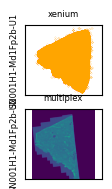

In [47]:
bigwarp.display_data_map(registered_data_map, multiplex_channel=multiplex_channel, gamma=.5)

## save registration metadata

In [48]:
yaml.safe_dump(registered_data_map, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [49]:
# just viewing
yaml.safe_dump(registered_data_map, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: xenium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s0_SN001H1-Md1Fp2b-U1_xenium.h5ad
  position: 0
  sid: SN001H1-Md1Fp2b-U1
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kelsey/SN001H1-Md1Fp2b/registered/s1_SN001H1-Md1Fp2b-U2_multiplex.ome.tiff
  position: 5
  sid: SN001H1-Md1Fp2b-U2
target_sid: SN001H1-Md1Fp2b-U1
